## Obtain data and explore it

In [1]:
# Kaggle dataset bootstrapping
OWNER_NAME = 'farjanakabirsamanta/'
DATASET_NAME = 'skin-cancer-dataset'

!pip install -qq kaggle

import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    path = Path('../input/'+DATASET_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / DATASET_NAME
    if not path.is_dir():
        print('about to download', OWNER_NAME+DATASET_NAME, 'to', DOWNLOADS)
        kaggle.api.dataset_download_files(OWNER_NAME+DATASET_NAME, path=DOWNLOADS)
        print('about to unzip', f'{path}.zip', 'to', path)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

 HAM10000_metadata.csv	'Skin Cancer'   models


In [3]:
!pip install -qq timm
!pip install -qq fastai
!pip install -qq pynvml

import timm 
from fastai.vision.all import *

In [4]:
df = pd.read_csv(path/'HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
len(df)

10015

In [6]:
df.dx_type.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [7]:
(df.dx_type == 'histo').value_counts()

True     5340
False    4675
Name: dx_type, dtype: int64

In [8]:
histo = df[df.dx_type == 'histo']
len(histo)

5340

In [9]:
histo.dx

0          bkl
1          bkl
2          bkl
3          bkl
4          bkl
         ...  
10010    akiec
10011    akiec
10012    akiec
10013    akiec
10014      mel
Name: dx, Length: 5340, dtype: object

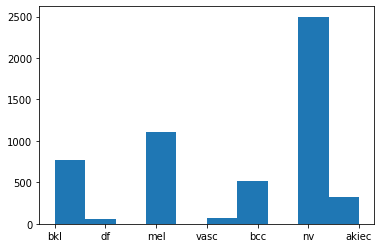

In [10]:
import matplotlib.pyplot as plt

plt.hist(histo.dx)
plt.show()

In [11]:
files = get_image_files(path)
files[0].stem
histo_files = [file for file in files if (df[df.image_id == file.stem].dx_type == 'histo').bool()]
len(histo_files)

5340

In [12]:
df[df.image_id == histo_files[0].stem].dx.iat[0]

'mel'

In [13]:
# check image sizes fast
from fastcore.parallel import *
def get_image_size(o): return PILImage.create(o).size
sizes = parallel(get_image_size, histo_files, n_workers=8)
pd.Series(sizes).value_counts()

(600, 450)    5340
dtype: int64

In [14]:
def label_func(fn):
    p = Path(fn)
    return df[df.image_id == p.stem].dx.iat[0]

In [15]:
dls = ImageDataLoaders.from_name_func(path, histo_files, label_func, item_tfms=Resize(128))
len(dls.train), len(dls.valid)

(66, 17)

In [16]:
xs, yx = dls.train.one_batch()
xs.shape

torch.Size([64, 3, 128, 128])

In [52]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.279613,1.482334,0.543071,00:26


epoch,train_loss,valid_loss,accuracy,time
0,1.549838,1.136626,0.625468,00:10
1,1.153110,0.985244,0.665730,00:10
2,0.831035,0.946782,0.685393,00:10


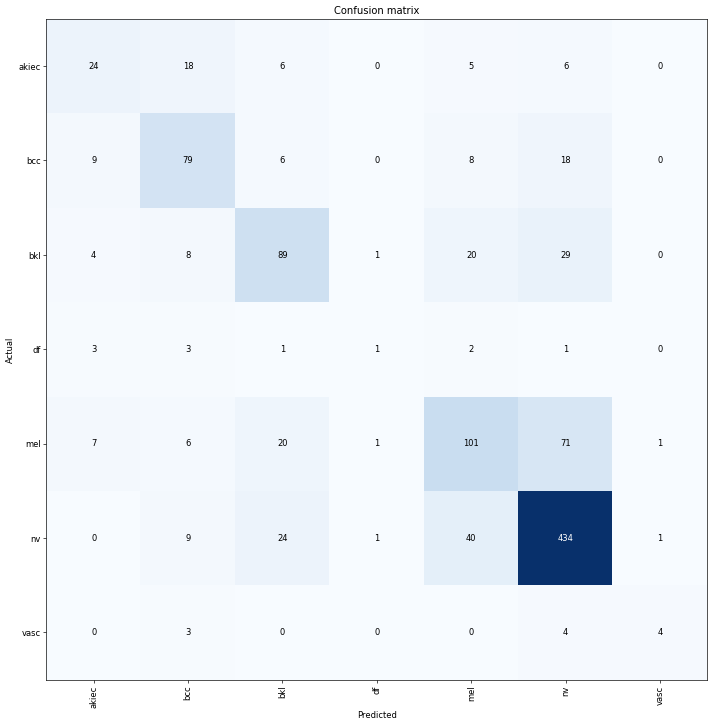

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [57]:
consensus = df[df.dx_type == 'consensus']
consensus_files = [file for file in files if (df[df.image_id == file.stem].dx_type == 'consensus').bool()]
len(consensus_files)

902

In [86]:
test_dl = dls.test_dl(consensus_files, with_labels=True)
preds, ys, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
ys[:5]

tensor([5, 6, 3, 5, 3])

In [79]:
preds[0]

TensorBase([2.9806e-04, 2.9875e-03, 5.8024e-05, 9.5239e-04, 2.0346e-04,
            9.9393e-01, 1.5656e-03])

In [87]:
accuracy(preds, ys)

TensorBase(0.5576)

## Let's train with all data and a bigger model

In [25]:
dls = ImageDataLoaders.from_name_func(path, 
            files, label_func, 
            batch_tfms=aug_transforms(size=128, min_scale=0.75),
            item_tfms=Resize(420))
len(dls.train), len(dls.valid)

(125, 32)

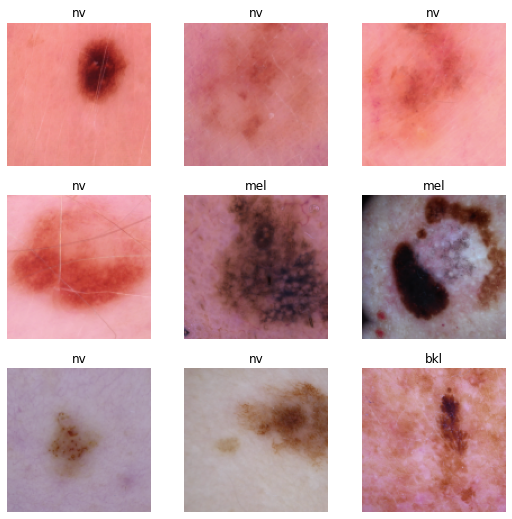

In [29]:
dls.show_batch()

In [26]:
import gc
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [36]:
report_gpu()

GPU:0
process      13772 uses     5495.000 MB GPU memory


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

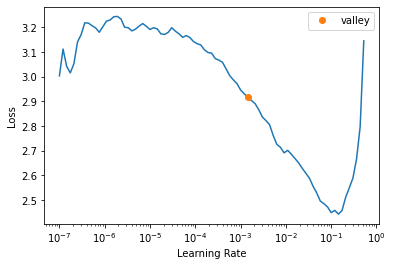

In [37]:
learn = vision_learner(dls, resnet101, metrics=accuracy)
learn.lr_find()

In [38]:
learn.fine_tune(8, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.210897,0.894271,0.724913,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.652764,0.641288,0.753869,00:32
1,0.615441,0.673050,0.769346,00:32
2,0.678823,0.666544,0.788817,00:32
3,0.587671,0.564258,0.803295,00:32
4,0.509167,0.526042,0.809785,00:32
5,0.426986,0.448245,0.833749,00:32
6,0.334095,0.416432,0.855217,00:32
7,0.288988,0.409203,0.857214,00:32


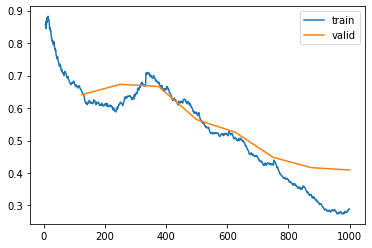

In [39]:
learn.recorder.plot_loss()

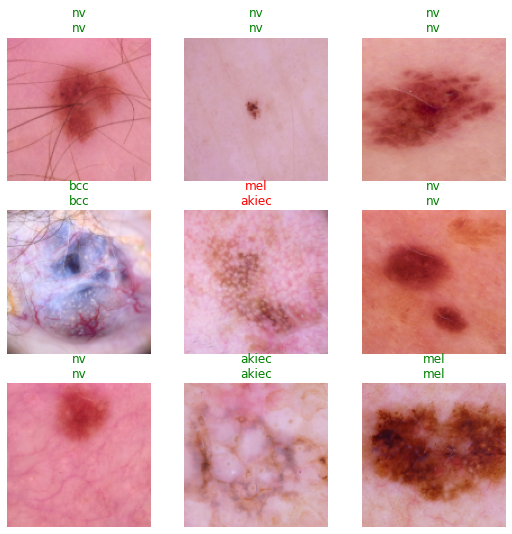

In [40]:
learn.show_results()

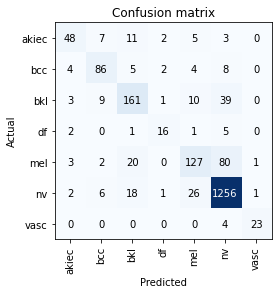

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Test it with an external image

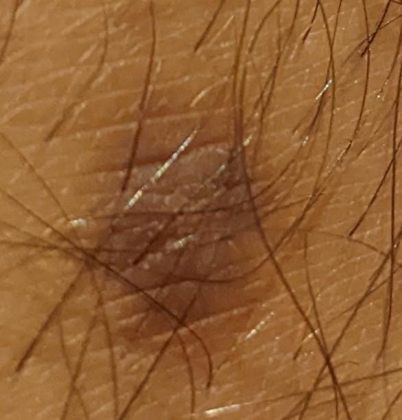

In [49]:
external = PILImage.create('external/2.jpeg')
external.thumbnail((420,420))
external

In [51]:
label, _, probs = learn.predict(external)

In [53]:
list(zip(learn.dls.vocab, probs))

[('akiec', TensorBase(0.0002)),
 ('bcc', TensorBase(0.0009)),
 ('bkl', TensorBase(0.0013)),
 ('df', TensorBase(0.0001)),
 ('mel', TensorBase(0.0003)),
 ('nv', TensorBase(0.9970)),
 ('vasc', TensorBase(0.0002))]